<a href="https://colab.research.google.com/github/Justabhi96/TF2.0/blob/master/19_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 33kB/s 
     |████████████████████████████████| 3.1MB 48.7MB/s 
     |████████████████████████████████| 501kB 39.6MB/s 


In [0]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#scaling the data in range (-1, 1)
X_train, X_test = X_train/255.0 *2 -1, X_test/255.0 *2 -1
X_train.shape

(60000, 28, 28)

In [0]:
# flatten the data
N, H, W = X_train.shape
D = H * W

X_train = X_train.reshape(-1, D)
X_test = X_test.reshape(-1, D)

In [0]:
# dimensionality of latent space
latent_dim = 100

In [0]:
# get the generator model
def build_generator(latent_dim):
  i = Input((latent_dim,))
  x = Dense(256, activation = LeakyReLU(alpha = 0.2))(i)
  x = BatchNormalization(momentum = 0.8)(x)
  x = Dense(512, activation = LeakyReLU(alpha = 0.2))(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = Dense(1024, activation = LeakyReLU(alpha = 0.2))(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = Dense(D, activation = "tanh")(x)

  model = Model(i, x)
  return model

In [0]:
# get the discriminator model
def build_discriminator(img_size):
  i = Input((img_size,))
  x = Dense(512, activation = LeakyReLU(alpha = 0.2))(i)
  x = Dense(256, activation = LeakyReLU(alpha = 0.2))(x)
  x = Dense(1, activation = "sigmoid")(x)

  model = Model(i, x)
  return model

In [0]:
# compile both model in preparation for training

# build and compile discriminator
discriminator = build_discriminator(D)
discriminator.compile(loss = "binary_crossentropy",
                      optimizer = Adam(0.0002, 0.5),
                      metrics = ["accuracy"])

# build and compile the combined model
generator = build_generator(latent_dim)

# create an input to represent noise sample from latent space
z = Input((latent_dim, ))

# pass noise through generator to get an image
img = generator(z)

# make sure only generator is trained
discriminator.trainable = False

# the true input is fake but we label them real
fake_pred = discriminator(img)

# create a combined model object
combined_model = Model(z, fake_pred)

# compile the combined model
combined_model.compile(loss = "binary_crossentropy",
                      optimizer = Adam(0.0002, 0.5))

In [0]:
# train the GAN

# config
batch_size = 32
epochs = 10000
sample_period = 200 # every "sample period" steps generate and save some data

# create batch labels to use when calling "train_on_batch"
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# store the loss
d_losses = []
g_losses = []

# create a folder to save generated images
if not os.path.exists("gan_images"):
  os.makedirs("gan_images")

In [0]:
# function to generate a grid of random samples from the generator and 
# save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows*cols, latent_dim)
  imgs = generator.predict(noise)

  # rescale images (0-1) for plotting
  imgs = 0.5 * imgs + 0.5 # prev range (-1, 1)

  fig, ax = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      ax[i, j].imshow(imgs[idx].reshape(H, W), cmap = "gray")
      ax[i, j].axis("off")
      idx += 1
  fig.savefig(f"gan_images/{epoch}.png")
  plt.close() 

In [0]:
# main training loop

for epoch in range(epochs):
   #######################
   # train discriminator #
   #######################

   # select a random batch of real images
   idx = np.random.randint(0, X_train.shape[0], batch_size)
   real_imgs = X_train[idx]

   # generate fake images
   noise = np.random.randn(batch_size, latent_dim)
   fake_imgs = generator.predict(noise)

   # train the discriminator
   # both loss and accuracy are returned
   d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
   d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
   d_loss = 0.5 * (d_loss_real + d_loss_fake)
   d_acc = 0.5 * (d_acc_real + d_acc_fake)

   ###################
   # train generator #
   ###################
   noise = np.random.randn(batch_size, latent_dim)
   g_loss = combined_model.train_on_batch(noise, ones)

   # save the model
   d_losses.append(d_loss)
   g_losses.append(g_loss)

   if epoch % 100 == 0:
     print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
   
   if epoch % sample_period == 0:
     sample_images(epoch)

epoch: 1/10000, d_loss: 0.81, d_acc: 0.28, g_loss: 0.67
epoch: 101/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 4.48
epoch: 201/10000, d_loss: 0.04, d_acc: 0.98, g_loss: 5.58
epoch: 301/10000, d_loss: 0.07, d_acc: 1.00, g_loss: 4.66
epoch: 401/10000, d_loss: 0.76, d_acc: 0.59, g_loss: 1.68
epoch: 501/10000, d_loss: 0.66, d_acc: 0.50, g_loss: 0.70
epoch: 601/10000, d_loss: 0.65, d_acc: 0.55, g_loss: 0.68
epoch: 701/10000, d_loss: 0.61, d_acc: 0.64, g_loss: 0.77
epoch: 801/10000, d_loss: 0.63, d_acc: 0.62, g_loss: 0.77
epoch: 901/10000, d_loss: 0.65, d_acc: 0.58, g_loss: 0.77
epoch: 1001/10000, d_loss: 0.59, d_acc: 0.69, g_loss: 0.79
epoch: 1101/10000, d_loss: 0.58, d_acc: 0.81, g_loss: 0.81
epoch: 1201/10000, d_loss: 0.64, d_acc: 0.72, g_loss: 0.82
epoch: 1301/10000, d_loss: 0.62, d_acc: 0.69, g_loss: 0.87
epoch: 1401/10000, d_loss: 0.59, d_acc: 0.69, g_loss: 0.94
epoch: 1501/10000, d_loss: 0.55, d_acc: 0.84, g_loss: 1.05
epoch: 1601/10000, d_loss: 0.51, d_acc: 0.80, g_loss: 0.99
epoch: 17

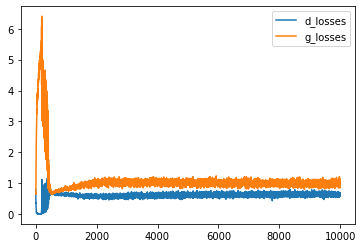

In [0]:
plt.plot(d_losses, label = "d_losses")
plt.plot(g_losses, label = "g_losses")
plt.legend()

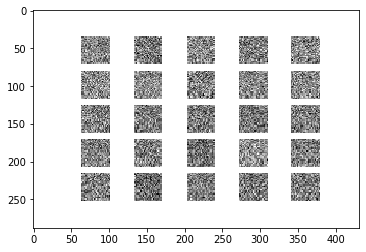

In [0]:
from skimage.io import imread
a = imread("gan_images/0.png")
plt.imshow(a)

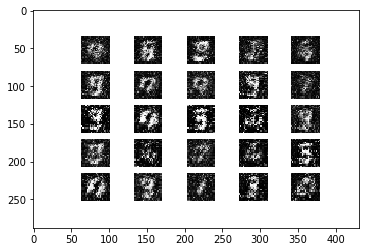

In [0]:
a = imread("gan_images/1000.png")
plt.imshow(a)

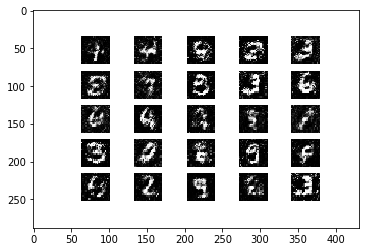

In [0]:
a = imread("gan_images/3000.png")
plt.imshow(a)

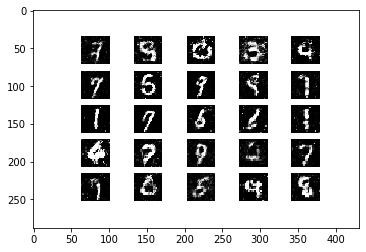

In [0]:
a = imread("gan_images/5000.png")
plt.imshow(a)

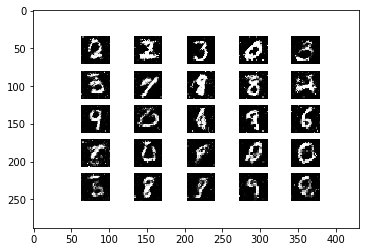

In [0]:
a = imread("gan_images/8000.png")
plt.imshow(a)

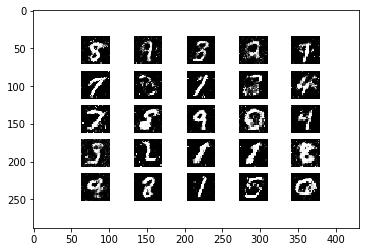

In [0]:
a = imread("gan_images/9800.png")
plt.imshow(a)

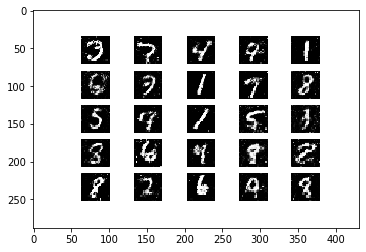

In [0]:
# generate the images after training of model
sample_images(111)
a = imread("gan_images/111.png")
plt.imshow(a)